### Importation des bibliothèques nécessaires

In [66]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [67]:
# Path du dataset
dataset_path = "C:\\Users\\yanis\\OneDrive\\Bureau\\Liv1_dataset"

#### Variables gobale

In [68]:
data_dir = dataset_path
image_h = 180
image_w = 180
batch_s = 32
epochs = 10

#### Collecte de données sur les images et création d'un DataFrame avec leurs caractéristiques

In [69]:
image_data = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    
    for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file == "desktop.ini":
                continue
            with Image.open(file_path) as image:
                image_data.append({
                    "FileName": file,
                    "Width": float(image.size[0]),
                    "Height": float(image.size[1]),
                    "Mode": image.mode,
                    "Category": folder,
                })

    print(f"Le dossier '{folder}' a été lu.")

images = pd.DataFrame(image_data)
images


Le dossier 'Painting' a été lu.
Le dossier 'Photo' a été lu.
Le dossier 'Schematics' a été lu.
Le dossier 'Sketch' a été lu.
Le dossier 'Text' a été lu.


,FileName,Width,Height,Mode,Category
0,painting_00001.jpg,710.0,768.0,RGB,Painting
1,painting_00002.jpg,597.0,561.0,RGB,Painting
2,painting_00003.jpg,750.0,600.0,RGB,Painting
3,painting_00004.jpg,1000.0,490.0,RGB,Painting
4,painting_00005.jpg,429.0,570.0,RGB,Painting
...,...,...,...,...,...
41394,text_09996.jpg,595.0,842.0,RGB,Text
41395,text_09997.jpg,595.0,842.0,RGB,Text
41396,text_09998.jpg,595.0,792.0,RGB,Text
41397,text_09999.jpg,595.0,792.0,RGB,Text


#### Analyse des modes de couleur dans le dataset d'images

In [71]:
images = pd.DataFrame(image_data)
modes_count = images["Mode"].value_counts().reset_index()
modes_count.columns = ["Mode", "Nombre"]
print("Le modes present dans notre dataset : ")
unique_modes = images["Mode"].unique()
print(unique_modes)
print(modes_count)

Le modes present dans notre dataset : 
['RGB' 'L' 'P' 'CMYK' 'RGBA']
   Mode  Nombre
0   RGB   40297
1     L    1091
2     P       5
3  RGBA       5
4  CMYK       1


#### Nombre d'images par catégorie dans le dataset

In [72]:
#Nombre d'image par categorie
category_names = []
image_counts = []

dataset_dir = os.listdir(dataset_path)

for directory in dataset_dir:
    files=os.listdir(os.path.join(dataset_path, directory))
    image_count = len(list(files))
    category_names.append(directory)
    image_counts.append(image_count)
    print("Nombre d'images dans "+ directory +" :", image_count)

Nombre d'images dans Painting : 10000
Nombre d'images dans Photo : 9993
Nombre d'images dans Schematics : 10001
Nombre d'images dans Sketch : 1406
Nombre d'images dans Text : 10000


#### Visualisation du nombre d'images par catégorie dans le dataset

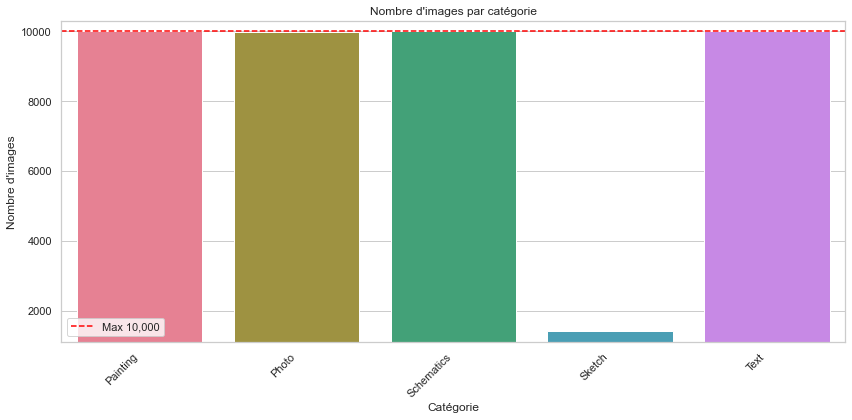

In [73]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=category_names, y=image_counts, palette="husl", linewidth=1)
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par catégorie')
plt.xticks(rotation=45, ha="right")

plt.ylim(min(image_counts) - 300, max(image_counts) + 300)
plt.axhline(y=10000, color='red', linestyle='--', label='Max 10,000')

plt.tight_layout()
plt.legend()
plt.show()


#### Liste des extensions de fichiers présentes dans le dataset

In [74]:
#Toutes les extension possibles de notre dataset
import os

extensions = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        file_extension = os.path.splitext(file)[1]

        if file_extension not in extensions:
            extensions.append(file_extension)

print("Extensions possibles dans le dataset :")
for extension in extensions:
    print(extension)
    


Extensions possibles dans le dataset :
.jpg
.ini
.png


#### Création des ensembles de données d'entraînement et de validation à partir du répertoire d'images

In [75]:
# Le train set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",  # déterminer automatiquement les étiquettes en se basant sur la structure du répertoire
  validation_split= 0.8, 
  subset = "training",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)
# Le test_set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",  # # déterminer automatiquement les étiquettes en se basant sur la structure du répertoire
  validation_split= 0.2,
  subset = "validation",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)

class_names = train_set.class_names
print(class_names)

Found 41399 files belonging to 5 classes.
Using 8280 files for training.
Found 41399 files belonging to 5 classes.
Using 8279 files for validation.
['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


#### Configuration de la Data Augmentation pour l'Entraînement du Modèle

Augmentation de la diversité des données d'entraînement 

In [76]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(image_h,image_w,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

### Construction du Modèle de Réseau de Neurones Convolutif (CNN)

In [77]:
# Le modèle (avec 2 couches de convolution)
model_two_layer = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.2),
  layers.Flatten(),
    
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])


In [78]:
# Compilation du modèle
model_two_layer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [79]:
# Résumé du modèle
model_two_layer.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

#### Utilisation de l'Arrêt Précoce (Early Stopping) pour Améliorer l'Entraînement du Modèle

L'arrêt précoce (Early Stopping) est une technique utilisée lors de l'entraînement de modèles  pour prévenir le surajustement et améliorer la convergence du modèle

In [80]:
# Callback pour l'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [81]:
# Entraînement du modèle
history = model_two_layer.fit(
  train_set,
  validation_data=validation_set,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/10
259/259 [==============================] - 93s 356ms/step - loss: 1.2959 - accuracy: 0.4795 - val_loss: 0.8861 - val_accuracy: 0.6194
Epoch 2/10
259/259 [==============================] - 111s 428ms/step - loss: 0.8550 - accuracy: 0.6335 - val_loss: 0.8274 - val_accuracy: 0.6397
Epoch 3/10
259/259 [==============================] - 136s 523ms/step - loss: 0.7820 - accuracy: 0.6629 - val_loss: 0.6501 - val_accuracy: 0.7290
Epoch 4/10
259/259 [==============================] - 129s 495ms/step - loss: 0.6462 - accuracy: 0.7223 - val_loss: 0.6243 - val_accuracy: 0.7379
Epoch 5/10
259/259 [==============================] - 133s 511ms/step - loss: 0.5992 - accuracy: 0.7415 - val_loss: 0.6109 - val_accuracy: 0.7495
Epoch 6/10
259/259 [==============================] - 127s 491ms/step - loss: 0.5580 - accuracy: 0.7599 - val_loss: 0.5344 - val_accuracy: 0.7764
Epoch 7/10
259/259 [==============================] - 130s 499ms/step - loss: 0.5439 - accuracy: 0.7657 - val_loss: 0.5196 - 

#### Visualisation de l'Évolution de l'Accuracy d'Entraînement et de Validation par Époque

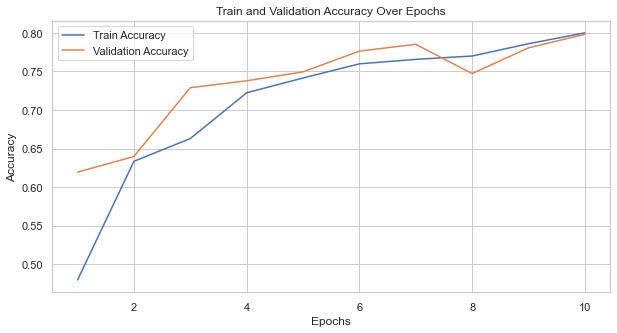

In [90]:
# Extraire les valeurs d'accuracy d'entraînement et de validation de l'historique
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Créer un graphique pour visualiser l'accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_accuracy, label='Train Accuracy')  # Remplacez 11 par le nombre total d'epochs
plt.plot(range(1, 11), val_accuracy, label='Validation Accuracy')  # Remplacez 11 par le nombre total d'epochs
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
